In [1]:
import tensorflow as tf
print(tf.__version__)

/Users/group_user/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.13.1


In [2]:
import keras
keras.__version__

'2.13.1'

In [3]:
import numpy as np
from matplotlib import pyplot as plt 
from patchify import patchify
import tifffile as tiff

In [4]:
import cv2

In [5]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

import os


# Change to whatever directory you want to save the predictions in
os.chdir(os.path.expanduser('~/Downloads'))


In [6]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

import os

# Define the custom loss function
def binary_crossentropy_plus_jaccard_loss(y_true, y_pred):
    bce = K.binary_crossentropy(y_true, y_pred)
    intersection = K.sum(y_true * y_pred, axis=-1)
    sum_ = K.sum(y_true + y_pred, axis=-1)
    jac = (intersection + K.epsilon()) / (sum_ - intersection + K.epsilon())
    return bce - K.log(jac + K.epsilon())

# Define the custom IoU score
def iou_score(y_true, y_pred):
    intersection = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    union = K.sum(K.round(K.clip(y_true + y_pred, 0, 1)))
    return intersection / (union + K.epsilon())

In [7]:
# Load the model with both the custom loss and IoU score function
# Choose whatever model you want to use for predictions
loaded_model = load_model('cell_body_segmentation_final.h5', custom_objects={
    'binary_crossentropy_plus_jaccard_loss': binary_crossentropy_plus_jaccard_loss,
    'iou_score': iou_score
})

print("Model loaded successfully.")

Model loaded successfully.


In [66]:
#read whatever stack of images you want to run predictions on
prediction_image_stack_4 = tiff.imread('/Users/group_user/Downloads/New Folder With Items 1.tif')

1664409600


In [67]:
#ensure that it is the right shape
print(prediction_image_stack_4.shape)

(301, 2560, 2160)


In [68]:
all_img_patches = []
size = (2048, 2048)

In [69]:
def process_images(prediction_image_stack, size, all_images):

    # Loop through each image in the prediction stack
    for img in range(prediction_image_stack.shape[0]):
        # Get the current image
        large_image_pred = prediction_image_stack[img] 
        # Resize the image to the desired size
        patches_img_pred = cv2.resize(large_image_pred, size)  

        # Normalize pixel values
        single_patch_img_pred = (patches_img_pred.astype('float32')) / 255.  
        # Append the processed image to the list
        all_images.append(single_patch_img_pred) 

In [72]:
#process all images in the stack
process_images(prediction_image_stack_4, size, all_img_patches)

In [73]:

images_pred = np.array(all_img_patches)
images_pred = np.stack((images_pred,)*3, axis=-1)

In [75]:
print(images_pred.shape)

(301, 2048, 2048, 3)


1/1 [==============================] - 1s 1s/step


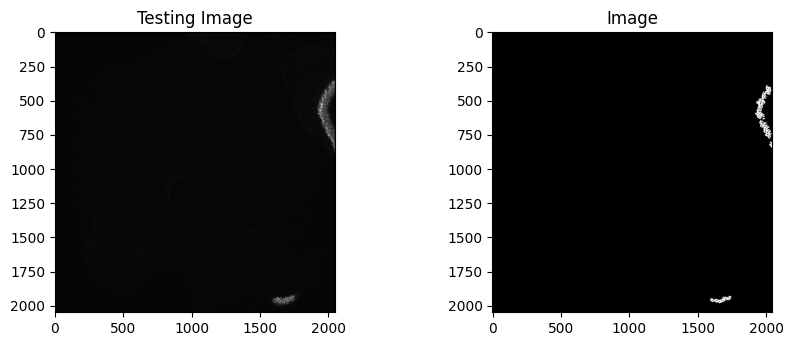

In [76]:
import random
# check if predictions are working
test_img_number_pred = random.randint(0, len(images_pred)-1)
test_img_pred = images_pred[test_img_number_pred]
test_img_input_pred = np.expand_dims(test_img_pred, 0)
prediction_pred = loaded_model.predict(test_img_input_pred)
test_img = images_pred[test_img_number_pred]
test_img_input = np.expand_dims(test_img, 0)

check_image = prediction_pred [0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Image')
plt.imshow(check_image, cmap='gray')
plt.show()

In [77]:
import os
import cv2
import numpy as np

def process_and_predict_images(prediction_image_stack, size, output_folder, model):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    saved_image_paths = []  # List to store paths of saved prediction images

    # Loop through each image in the prediction stack
    for img in range(prediction_image_stack.shape[0]):
        # Get the current image
        image = prediction_image_stack[img]  
        single_image = np.expand_dims(image, 0)
        
        # Make prediction
        prediction = model.predict(single_image)  
        
        
        prediction_image = prediction[0]  
        prediction_image = (prediction_image * 255).astype('uint8') 

        # Construct the output file path
        output_file_path = os.path.join(output_folder, f'prediction_cell_body_{img}.png')

        # Save the predicted image
        cv2.imwrite(output_file_path, prediction_image)
        saved_image_paths.append(output_file_path)  

    return saved_image_paths

In [ ]:
size = (2048, 2048)  # Example size
output_folder = 'predictions_cell_body_final_2'  # Folder where predictions will be saved

# Call the function with the model
saved_image_paths = process_and_predict_images(images_pred, size, output_folder, loaded_model)


1/1 [==============================] - 1s 1s/step
